l'objectif de ce notebook est de creer un reseaux de neuronnes pour générer du texte comme victor hugo

In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd

# lecture du texte

In [5]:
path_to_file = 'victor_hugo-texts.txt'

In [6]:
text = open(path_to_file, 'r').read()
len(text)

97487

# Traitement des données et Tokenization

on constate que chaque ligne de texte est séparé par \n, on va donc utiliser la fonction `split()` pour séparer le texte en sequences, ou chaque séquence correspond a une ligne

la fonction `lower()` nous renvoie le text mais avec toutes les lettres en minuscule

In [7]:
corpus = text.lower().split("\n") 
corpus[:50]

['mes vers fuiraient',
 '',
 'mes vers fuiraient, doux et frêles, vers votre jardin si beau,',
 'si mes vers avaient des ailes,',
 "des ailes comme l'oiseau.",
 '',
 '',
 'ils voleraient, étincelles, vers votre foyer qui rit,',
 'si mes vers avaient des ailes,',
 "des ailes comme l'esprit.",
 '',
 "près de vous, purs et fidèles, ils accourraient, nuit et jour, si mes vers avaient des ailes, des ailes comme l'amour!",
 '',
 'victor hugo: les contemplations paris, 22 mars 1841',
 '',
 'ce siècle avait deux ans',
 '\t\t ',
 'ce siècle avait deux ans. rome remplaçait sparte, déjà napoléon perçait sous bonaparte,',
 'et du premier consul déjà, par maint endroit,',
 "le front de l'empereur brisait le masque étroit. alors dans besançon, vieille ville espagnole, jeté comme la graine au gré de l'air qui vole, naquit d'un sang breton et lorrain à la fois",
 "un enfant sans couleur, sans regard et sans voix ; si débile qu'il fut, ainsi qu'une chimère, abandonné de tous, excepté de sa mère,",
 'et

importation de la bibliotheque nous permettant de creer des token, cela va découper le text en mot

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

on va creer une instance de tokenizer, tokenizer va par lui meme supprimer les espaces, la ponctuation etc pour ne retenir que les mots

on va ensuite génerer des token depuis notre coprus avec la fonction fit_on_texts()

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

le tokenizer associe a chaque mot un index, nous pouvons récuperer ces index avec `tokenizer.index_word`

In [10]:
vocab = tokenizer.index_word

In [11]:
total_word = len(vocab)
print(total_word)

4138


Maintenant que nous avons convertit chaque mot en un token et que nous lui avons associé une valeur numérique, il faut convertir notre texte en sequence de nombre 

dans ce premier example nous allons juste convertir la premiere ligne 

In [12]:
token_list = tokenizer.texts_to_sequences([corpus[0]])[0]

In [13]:
corpus[0]

'mes vers fuiraient'

In [14]:
token_list

[109, 93, 914]

Maintenant nous allons convertir tout le texte

dans la premire boucle for nous convertissons chaque ligne du texte en sequence, puis dans la seconde boucle nous créons pour chaque ligne des listes comme suit :

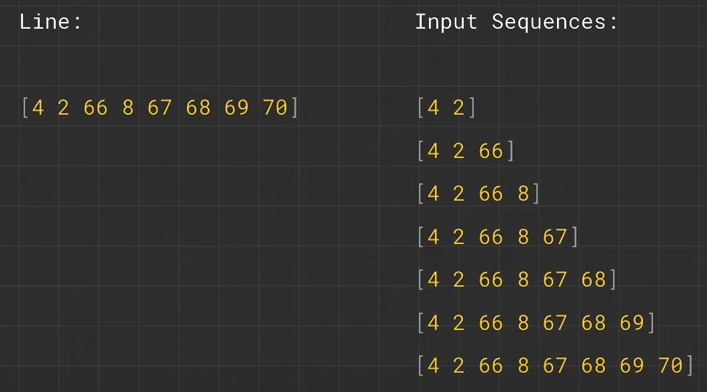

In [15]:
input_sequences = []
for line in corpus:
    token_list=tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
      n_gram_sequence = token_list[:i+1]
      input_sequences.append(n_gram_sequence)



# Padding et generator

nous allons maintenant "padder" nos sequence, c'est a dire que nous allons les rendre toutes de la meme taille, en ajoutant des 0

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

retourne la longueur de la sequence la plus longue

In [17]:
max_len_sequence = max([len(x) for x in input_sequences])
max_len_sequence

66

In [18]:
padded = pad_sequences(input_sequences,maxlen=max_len_sequence,padding='pre')

In [19]:
padded[1204]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   34, 1759,    5,  701,    1, 1760,   10],
      dtype=int32)

voila le resultat apres le padding :

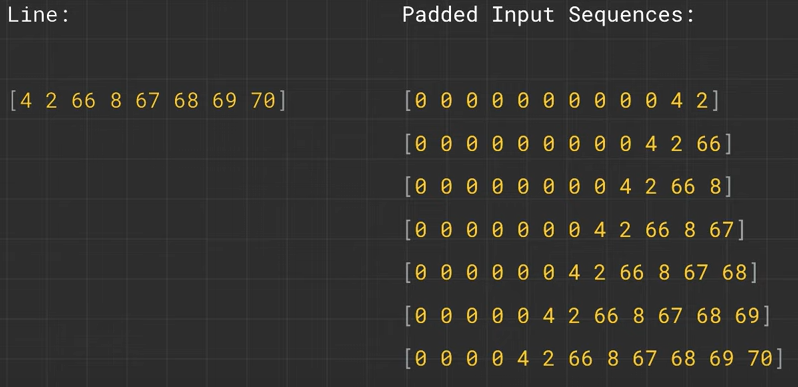

On va pouvoir maintenant indiquer un input et une target comme suit :
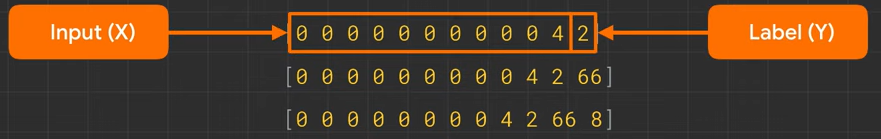

Et ainsi de suite 

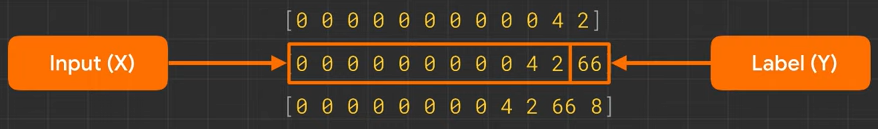

on va donc indiquer que xs va prendre toutes les valeurs sauf la derniere, et labels va uniquement prendre la derneire

In [20]:
xs = padded[:,:-1]
labels = padded[:,-1]

In [21]:
print(xs[1])
print(labels[0])
print(len(xs))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0 109  93]
93
15208


Nous voulons que nos labels soient en one hot encoding ( categorical ), comme ca nous allons a la sortie du reseau regarder quel est le mot qui a plus forte probabilité d'etre a la suite

In [22]:
ys = tf.keras.utils.to_categorical(labels, num_classes=total_word+1)

In [23]:
print(len(ys[0]))

4139


In [24]:
print(ys[0])

[0. 0. 0. ... 0. 0. 0.]


Nous avons donc une sentence, que nous allons découper en X et labels, ou Labels est le dernier element et X le reste, puis nous allons coder Labels en one hot encoding, c'est adire qu'au lieu d'avoir 70 nous allons obtenir une matrice remplie de 0 sauf a l'indice 70 ou il y a un 1

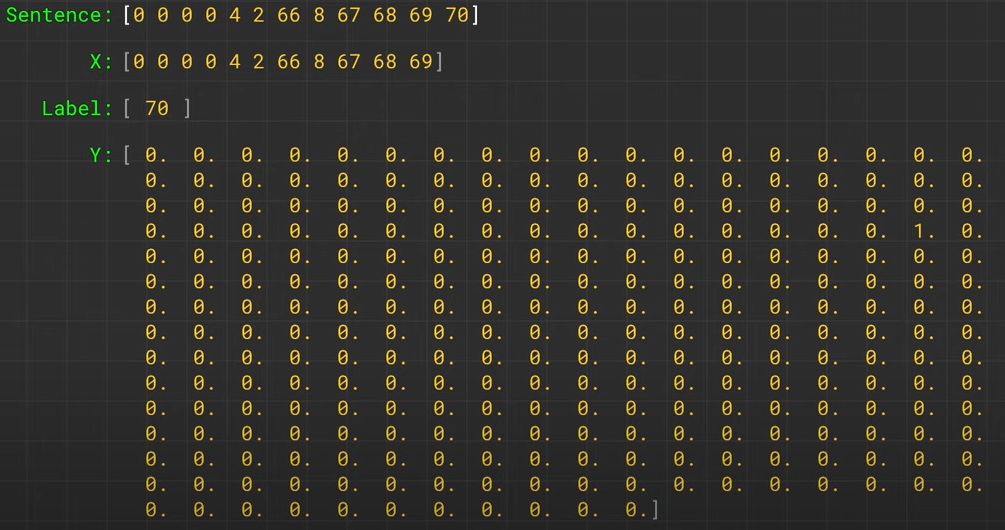

# Creation du modele

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding

In [26]:
model = Sequential()
model.add(Embedding(total_word,240,input_length=max_len_sequence-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_word+1,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(xs,ys, epochs=30,verbose=1)

Epoch 1/30
476/476 [==============================] - 58s 55ms/step - loss: 7.4428 - accuracy: 0.0246
Epoch 2/30
476/476 [==============================] - 27s 57ms/step - loss: 6.6658 - accuracy: 0.0371
Epoch 3/30
476/476 [==============================] - 27s 56ms/step - loss: 6.2603 - accuracy: 0.0539
Epoch 4/30
476/476 [==============================] - 26s 55ms/step - loss: 5.7642 - accuracy: 0.0793
Epoch 5/30
476/476 [==============================] - 26s 55ms/step - loss: 5.2085 - accuracy: 0.1166
Epoch 6/30
476/476 [==============================] - 26s 55ms/step - loss: 4.6269 - accuracy: 0.1526
Epoch 7/30
476/476 [==============================] - 26s 55ms/step - loss: 4.1333 - accuracy: 0.2124
Epoch 8/30
476/476 [==============================] - 26s 55ms/step - loss: 3.6207 - accuracy: 0.3059
Epoch 9/30
476/476 [==============================] - 26s 55ms/step - loss: 3.1452 - accuracy: 0.3933
Epoch 10/30
476/476 [==============================] - 26s 56ms/step - loss: 2.721

on sauvegarde le modele 

In [28]:
model.save('victor_hugo.h5')

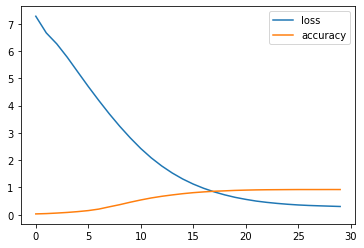

In [30]:
losses = pd.DataFrame(model.history.history)
losses.plot()

# Generation de texte

In [97]:
seed_text = "Je pense que"
next_words = 20
for i in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0] 
  token_list = pad_sequences([token_list],maxlen=max_len_sequence, padding='pre')   
  predicted = model.predict_classes(token_list,verbose=0)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Je pense que le matin veut un baiser de sa maison me flamme en flamme sur son noir fanal puisse notre ronde vient
